
02_model_training.ipynb : Modélisation et Tracking MLflow

 **Objectif :** Entraîner une baseline et un modèle avancé, en gérant le déséquilibre des classes et en traquant les performances (notamment le coût métier) via MLflow.



In [23]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from mlflow.models.signature import infer_signature
import sys
import os
import lightgbm as lgb
import xgboost as xgb

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from model_utils import (
    prepare_data_for_training, 
    train_cv_and_log, 
    plot_business_cost_threshold,
    optimize_hyperparameters_optuna,
    optimize_hyperparameters_xgboost,
    export_model_to_folder
)

from metrics import custom_business_cost

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuration mlflow
La fonction `prepare_data_for_training` charge les CSV, nettoie les noms de colonnes (pour éviter l'erreur JSON LightGBM), gère les infinis, et effectue le split stratifié.

In [24]:
EXPERIMENT_NAME = "Credit_Scoring_Final"
mlflow.set_tracking_uri("file:mlruns")

PATH_TRAIN = '../datasets/final/train_enriched.csv'
PATH_LABELS = '../datasets/final/train_labels.csv'

X_train, X_val, y_train, y_val = prepare_data_for_training(PATH_TRAIN, PATH_LABELS)

print(f"Données chargées. Train shape: {X_train.shape}")

Chargement des données...
Nettoyage des noms de colonnes...
Split Train/Validation (Stratifié)...
Données chargées. Train shape: (238008, 1845)


In [25]:
X_train.shape

(238008, 1845)

## Validation croisée avec Baseline, LightGBM et XGBoost
Nous comparons la robustesse des modèles sur 5 plis (folds).

#### MODELE : BASELINE (Régression Logistique)
Pipeline nécessaire pour gérer les NaN
On utilise X_train pour la CV (le set de validation final X_val est gardé pour l'optimisation du seuil)

In [26]:
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(C=1.0, class_weight='balanced', max_iter=500))
])

print("\n--- Cross-Validation: Baseline ---")
model_lr_cv, cost_lr = train_cv_and_log(
    pipe_lr, X_train, y_train, EXPERIMENT_NAME, "CV_Baseline_LogReg"
)

c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/12 19:49:12 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Scoring_Final' does not exist. Creating a new experiment.



--- Cross-Validation: Baseline ---
--- Cross-Validation (5 folds) : CV_Baseline_LogReg ---


c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://s

  >> Moyenne CV: Coût=24189.0 | AUC=0.772


c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid 

#### MODELE : XGBoost

In [27]:
ratio_equilibrage = (y_train == 0).sum() / (y_train == 1).sum()

xg = xgb.XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=ratio_equilibrage,
    n_estimators=300,             
    learning_rate=0.05,                                 
    n_jobs=3,                     
    random_state=42
)

print("\n--- Cross-Validation: XGBoost ---")
model_xgb_cv, cost_xgb = train_cv_and_log(
    xg, X_train, y_train, EXPERIMENT_NAME, "CV_XGBoost_Default"
)


--- Cross-Validation: XGBoost ---
--- Cross-Validation (5 folds) : CV_XGBoost_Default ---
  >> Moyenne CV: Coût=23685.0 | AUC=0.782


c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/12 20:10:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


On utilise `optuna` pour rechercher les meilleurs hyperparamètres de XGBoost.

In [28]:
X_sample = X_train.sample(frac=0.2, random_state=42)
y_sample = y_train[X_sample.index]

print("Lancement de l'optimisation Optuna...")
best_params = optimize_hyperparameters_xgboost(
    X_sample, 
    y_sample, 
    experiment_name=EXPERIMENT_NAME, 
    n_trials=50
)

[I 2025-12-12 20:10:15,515] A new study created in memory with name: no-name-7fdfa5b9-701a-4c10-bceb-d0015357563d


Lancement de l'optimisation Optuna...
--- Optimisation Optuna XGBoost (50 essais) ---


[I 2025-12-12 20:12:33,109] Trial 0 finished with value: 0.7729099517367427 and parameters: {'learning_rate': 0.014329692248645892, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 3.9524244509408835, 'subsample': 0.6642026006490762, 'colsample_bytree': 0.9579861455095176, 'reg_alpha': 0.0013910953177793477, 'reg_lambda': 5.414443052033548, 'n_estimators': 825}. Best is trial 0 with value: 0.7729099517367427.
[I 2025-12-12 20:12:57,391] Trial 1 finished with value: 0.7397062243223232 and parameters: {'learning_rate': 0.25076190010661775, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 3.040326653002832, 'subsample': 0.6826546675996008, 'colsample_bytree': 0.894829600036172, 'reg_alpha': 7.8770631076736e-06, 'reg_lambda': 2.23033741220709, 'n_estimators': 843}. Best is trial 0 with value: 0.7729099517367427.
[I 2025-12-12 20:15:34,650] Trial 2 finished with value: 0.7681124549492928 and parameters: {'learning_rate': 0.013203643311007419, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.

Meilleurs params: {'learning_rate': 0.014329692248645892, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 3.9524244509408835, 'subsample': 0.6642026006490762, 'colsample_bytree': 0.9579861455095176, 'reg_alpha': 0.0013910953177793477, 'reg_lambda': 5.414443052033548, 'n_estimators': 825}


In [29]:
print(best_params)

{'learning_rate': 0.014329692248645892, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 3.9524244509408835, 'subsample': 0.6642026006490762, 'colsample_bytree': 0.9579861455095176, 'reg_alpha': 0.0013910953177793477, 'reg_lambda': 5.414443052033548, 'n_estimators': 825, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'scale_pos_weight': np.float64(11.520252498684902)}


Meilleurs paramètres trouvés 

In [30]:
print("Utilisation des paramètres manuels ...")

fixed_params = {
    'learning_rate': 0.012869177845618215, 
    'max_depth': 3, 'min_child_weight': 6, 
    'gamma': 4.337049477691507, 
    'subsample': 0.879838115636258, 
    'colsample_bytree': 0.5121645433524673, 
    'reg_alpha': 0.0022522357241632762, 
    'reg_lambda': 6.918217406817744e-06, ''
    'n_estimators': 894, 
    'objective': 'binary:logistic', 
}

Utilisation des paramètres manuels ...


In [31]:
print("\nEntraînement du modèle final XGBoost...")

ratio_equilibrage = (y_train == 0).sum() / (y_train == 1).sum()

best_xgb = xgb.XGBClassifier(
    **fixed_params,          
    scale_pos_weight=ratio_equilibrage,
    n_jobs=-1,              
    random_state=42,
    eval_metric='auc',
    early_stopping_rounds=100
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=1
)
print("\n--- Évaluation du Modèle ---")
y_val_proba = best_xgb.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC Score : {auc_score:.4f}")


Entraînement du modèle final XGBoost...
[0]	validation_0-auc:0.64891
[1]	validation_0-auc:0.69171
[2]	validation_0-auc:0.68958
[3]	validation_0-auc:0.69531
[4]	validation_0-auc:0.69769
[5]	validation_0-auc:0.69742
[6]	validation_0-auc:0.69807
[7]	validation_0-auc:0.69887
[8]	validation_0-auc:0.70427
[9]	validation_0-auc:0.70663
[10]	validation_0-auc:0.71111
[11]	validation_0-auc:0.71274
[12]	validation_0-auc:0.71440
[13]	validation_0-auc:0.71704
[14]	validation_0-auc:0.71714
[15]	validation_0-auc:0.71798
[16]	validation_0-auc:0.71825
[17]	validation_0-auc:0.71793
[18]	validation_0-auc:0.71716
[19]	validation_0-auc:0.71719
[20]	validation_0-auc:0.71691
[21]	validation_0-auc:0.71654
[22]	validation_0-auc:0.71714
[23]	validation_0-auc:0.71750
[24]	validation_0-auc:0.71722
[25]	validation_0-auc:0.71691
[26]	validation_0-auc:0.71757
[27]	validation_0-auc:0.71847
[28]	validation_0-auc:0.71951
[29]	validation_0-auc:0.72049
[30]	validation_0-auc:0.72141
[31]	validation_0-auc:0.72162
[32]	vali

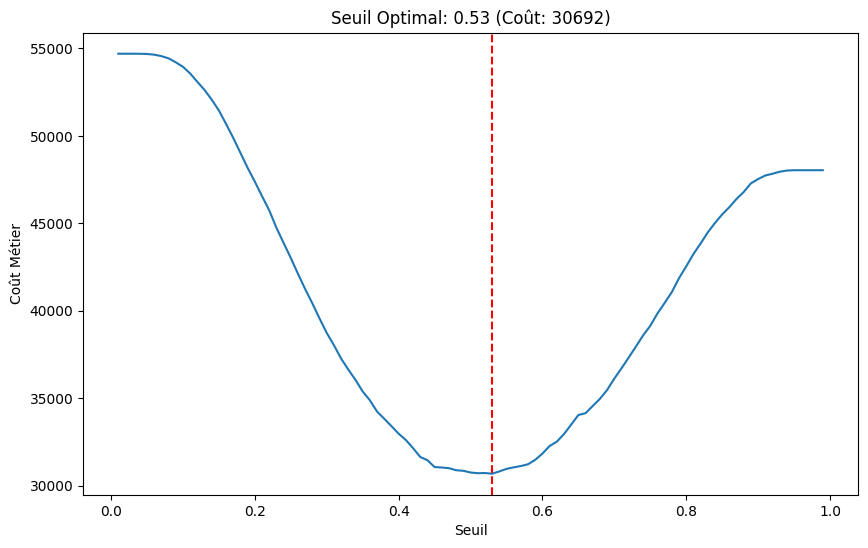

In [32]:
fig, best_thresh = plot_business_cost_threshold(y_val, y_val_proba)
plt.show()

On sauvegarde le modele final de XGBoost dans MLflow en utilisant export_model_to_folder() pour exporter vers model/

In [33]:
print(f"\n>>> MODÈLE FINAL XGBOOST OPTIMISÉ <<<")
print(f"Seuil de décision : {best_thresh:.3f}")

with mlflow.start_run(run_name="Final_Model_XGBOOST"):
    mlflow.log_params(fixed_params)
    mlflow.log_param("optimal_threshold", best_thresh)
    
    y_pred_optimal = (y_val_proba >= best_thresh).astype(int)
    from metrics import get_metrics
    metrics = get_metrics(y_val, y_pred_optimal, y_val_proba)
    mlflow.log_metrics(metrics)
    
    mlflow.log_figure(fig, "business_cost_curve.png")
    
    signature = infer_signature(X_train, best_xgb.predict(X_train))
    mlflow.sklearn.log_model(
        best_xgb, 
        "modelXGB",  # Nom de l'artefact dans MLflow 
        signature=signature,
        input_example=X_train.iloc[:5]
    )
    
    final_run_id = mlflow.active_run().info.run_id
    print(f"\nModèle loggé dans MLflow avec run_id: {final_run_id}")
    print(f"   Utilisez export_model_to_folder(run_id='{final_run_id}') pour exporter vers model/")


>>> MODÈLE FINAL XGBOOST OPTIMISÉ <<<
Seuil de décision : 0.530


c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/12 20:33:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Modèle loggé dans MLflow avec run_id: 9e6436f48b1e42e883b290f9437d6fb3
   Utilisez export_model_to_folder(run_id='9e6436f48b1e42e883b290f9437d6fb3') pour exporter vers model/


#### MODELE : LightGBM (Avancé)

In [34]:
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    class_weight='balanced',
    n_jobs=3,
    random_state=42,
    verbose=-1
)

print("\n--- Cross-Validation: LightGBM ---")
model_lgbm_cv, cost_lgbm = train_cv_and_log(
    lgbm, X_train, y_train, EXPERIMENT_NAME, "CV_LightGBM_Default"
)


--- Cross-Validation: LightGBM ---
--- Cross-Validation (5 folds) : CV_LightGBM_Default ---
  >> Moyenne CV: Coût=23320.4 | AUC=0.785


c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/12 20:42:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


On utilise `optuna` pour rechercher les meilleurs hyperparamètres de LightGBM.

In [35]:
X_sample = X_train.sample(frac=0.2, random_state=42)
y_sample = y_train[X_sample.index]

print("Lancement de l'optimisation Optuna...")
best_params = optimize_hyperparameters_optuna(
    X_sample, 
    y_sample, 
    experiment_name=EXPERIMENT_NAME, 
    n_trials=50
)

[I 2025-12-12 20:43:11,240] A new study created in memory with name: no-name-b7e6c4fa-9b83-4fe6-a3b1-f0a46de453e0


Lancement de l'optimisation Optuna...
--- Optimisation Optuna (50 essais) ---


[I 2025-12-12 20:45:14,143] Trial 0 finished with value: 0.7573466641384416 and parameters: {'n_estimators': 853, 'learning_rate': 0.01644919603908892, 'num_leaves': 59, 'max_depth': 9, 'reg_alpha': 0.6541758033936385, 'reg_lambda': 2.3656726129017864e-07, 'colsample_bytree': 0.7052173522824406, 'subsample': 0.7375139851733978}. Best is trial 0 with value: 0.7573466641384416.
[I 2025-12-12 20:47:22,748] Trial 1 finished with value: 0.7689214237754408 and parameters: {'n_estimators': 701, 'learning_rate': 0.017317920266194612, 'num_leaves': 56, 'max_depth': 13, 'reg_alpha': 2.2500298665126364e-05, 'reg_lambda': 3.8859563838228546, 'colsample_bytree': 0.6462002873676703, 'subsample': 0.8931778207006195}. Best is trial 1 with value: 0.7689214237754408.
[I 2025-12-12 20:48:14,198] Trial 2 finished with value: 0.7382903022615972 and parameters: {'n_estimators': 616, 'learning_rate': 0.0618949314175144, 'num_leaves': 37, 'max_depth': 6, 'reg_alpha': 0.0002531422177279376, 'reg_lambda': 7.405

Meilleurs params: {'n_estimators': 448, 'learning_rate': 0.010739405431886465, 'num_leaves': 28, 'max_depth': 11, 'reg_alpha': 0.0005794401759657611, 'reg_lambda': 0.0016265661670098771, 'colsample_bytree': 0.6797552415283589, 'subsample': 0.5367765358699895}


Meilleurs paramètres trouvés 

In [36]:
print("Utilisation des paramètres manuels ...")

fixed_params = {
    'n_estimators': 536,
    'learning_rate': 0.0146,       
    'num_leaves': 53,
    'max_depth': 11,
    'reg_alpha': 6.132,            
    'reg_lambda': 1.45e-07,        
    'colsample_bytree': 0.915,
    'subsample': 0.977
}

Utilisation des paramètres manuels ...


On relance le modele LightGBM mais optimisé.

In [37]:
print("\nEntraînement du modèle final LightGBM...")
best_lgbm = LGBMClassifier(
    **fixed_params,          
    class_weight='balanced',
    n_jobs=-1,              
    random_state=42,
    verbose=1
)

best_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=200)]
)
print("\n--- Évaluation du Modèle ---")
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC Score : {auc_score:.4f}")


Entraînement du modèle final LightGBM...
[LightGBM] [Info] Number of positive: 19214, number of negative: 218794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.548631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211255
[LightGBM] [Info] Number of data points in the train set: 238008, number of used features: 1837
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.761581	valid_0's binary_logloss: 0.566884
[400]	valid_0's auc: 0.775064	valid_0's binary_logloss: 0.537462
Did not meet early stopping. Best iteration is:
[536]	valid_0's auc: 0.778613	valid_0's binary_logloss: 0.52455

--- Évaluation du Modèle ---
ROC AUC Score : 0.7786


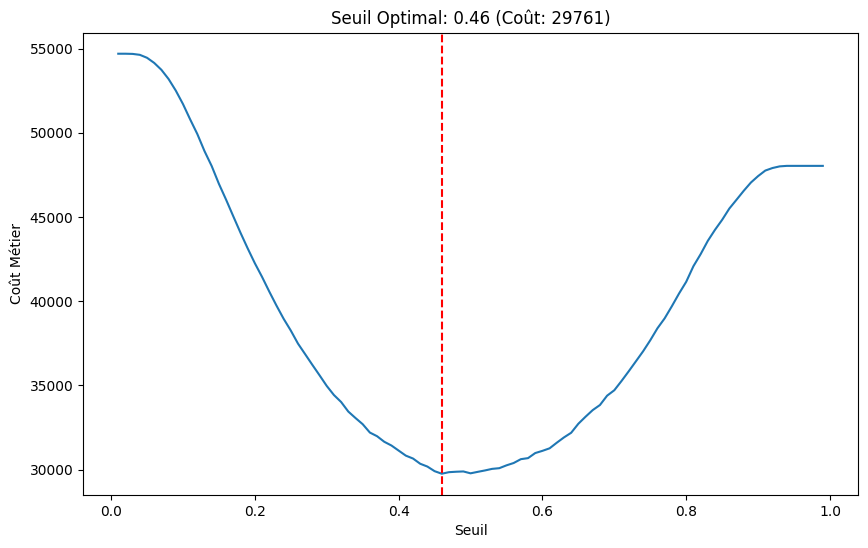

In [38]:
fig, best_thresh = plot_business_cost_threshold(y_val, y_val_proba)
plt.show()

On sauvegarde le modele final dans MLflow en utilisant export_model_to_folder() pour exporter vers model/

In [39]:
print(f"\n>>> MODÈLE FINAL OPTIMISÉ <<<")
print(f"Seuil de décision : {best_thresh:.3f}")

with mlflow.start_run(run_name="Final_Model_Optuna"):
    mlflow.log_params(fixed_params)
    mlflow.log_param("optimal_threshold", best_thresh)
    
    y_pred_optimal = (y_val_proba >= best_thresh).astype(int)
    from metrics import get_metrics
    metrics = get_metrics(y_val, y_pred_optimal, y_val_proba)
    mlflow.log_metrics(metrics)
    
    mlflow.log_figure(fig, "business_cost_curve.png")
    
    signature = infer_signature(X_train, best_lgbm.predict(X_train))
    mlflow.sklearn.log_model(
        best_lgbm, 
        "model",  # Nom de l'artefact dans MLflow 
        signature=signature,
        input_example=X_train.iloc[:5]
    )
    
    final_run_id = mlflow.active_run().info.run_id
    print(f"\nModèle loggé dans MLflow avec run_id: {final_run_id}")
    print(f"   Utilisez export_model_to_folder(run_id='{final_run_id}') pour exporter vers model/")


>>> MODÈLE FINAL OPTIMISÉ <<<
Seuil de décision : 0.460


c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/12 21:09:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Modèle loggé dans MLflow avec run_id: 0907206f98954aa1899be7f2b20958d8
   Utilisez export_model_to_folder(run_id='0907206f98954aa1899be7f2b20958d8') pour exporter vers model/


#### Historigramme des probabilités et comparaison
On effectue la recherche du seuil avec `thresholds`.

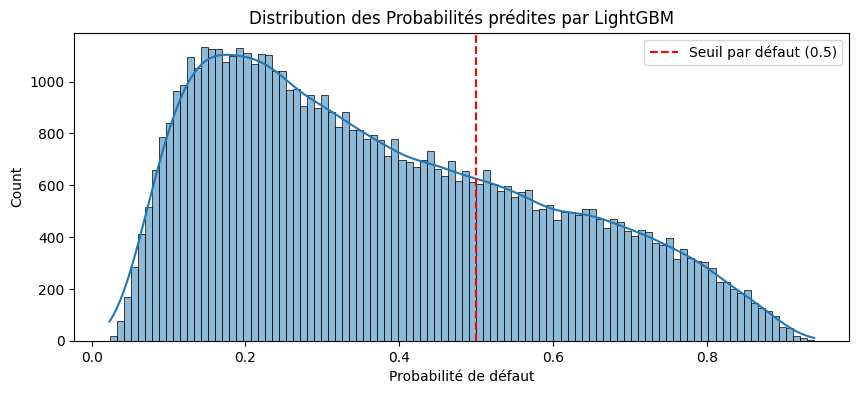

Probabilité Min: 0.0234
Probabilité Moyenne: 0.3793
Probabilité Max: 0.9395

--- RÉSULTAT CORRIGÉ ---
Seuil Optimal Réel : 0.460
Coût Minimum : 29761
Coût avec seuil 0.50 : 29785
Économie réalisée : 24 points

--- Performance au Seuil Optimal ---
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     54699
           1       0.17      0.73      0.28      4804

    accuracy                           0.70     59503
   macro avg       0.57      0.71      0.54     59503
weighted avg       0.90      0.70      0.77     59503



In [40]:
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]

plt.figure(figsize=(10, 4))
sns.histplot(y_val_proba, bins=100, kde=True)
plt.axvline(0.5, color='r', linestyle='--', label="Seuil par défaut (0.5)")
plt.title("Distribution des Probabilités prédites par LightGBM")
plt.xlabel("Probabilité de défaut")
plt.legend()
plt.show()

print(f"Probabilité Min: {y_val_proba.min():.4f}")
print(f"Probabilité Moyenne: {y_val_proba.mean():.4f}")
print(f"Probabilité Max: {y_val_proba.max():.4f}")

thresholds = np.arange(0.01, 0.95, 0.005) 
costs = []

for thresh in thresholds:
    y_pred_t = (y_val_proba >= thresh).astype(int)
    cost = custom_business_cost(y_val, y_pred_t) 
    costs.append(cost)

min_cost_index = np.argmin(costs)
real_best_thresh = thresholds[min_cost_index]
min_cost_val = costs[min_cost_index]

print(f"\n--- RÉSULTAT CORRIGÉ ---")
print(f"Seuil Optimal Réel : {real_best_thresh:.3f}")
print(f"Coût Minimum : {min_cost_val}")


y_pred_05 = (y_val_proba >= 0.5).astype(int)
cost_05 = custom_business_cost(y_val, y_pred_05)

print(f"Coût avec seuil 0.50 : {cost_05}")
print(f"Économie réalisée : {cost_05 - min_cost_val} points")

y_pred_final = (y_val_proba >= real_best_thresh).astype(int)
print("\n--- Performance au Seuil Optimal ---")
print(classification_report(y_val, y_pred_final))

## Export du Modèle pour Docker

Une fois le modèle final entraîné et loggé dans MLflow, on l'exporte vers le dossier `model/` pour le Dockerfile.

Option 1 : Exporter depuis un run_id spécifique
```python
export_model_to_folder(run_id="af5897f2130b491a9c3ce5320561668f")
```

Option 2 : Exporter depuis le registry MLflow
```python
export_model_to_folder(
    model_name="model",
    experiment_name="Credit_Scoring_Final"
)
```



In [43]:
export_model_to_folder(run_id="7bc1ee0c7c8c4792a6272460b1cef1cb")

"""export_model_to_folder(
    model_name="model",
    experiment_name=EXPERIMENT_NAME,
    tracking_uri="file:../mlruns"
)"""

print("\nLe modèle est maintenant prêt pour Docker !")
print("Vous pouvez construire l'image avec: docker build -t credit-scoring-model .")



Export depuis run_id: 7bc1ee0c7c8c4792a6272460b1cef1cb
Téléchargement du modèle depuis MLflow...


MlflowException: Run '7bc1ee0c7c8c4792a6272460b1cef1cb' not found